In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Inspect to get columns
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

Most recent date in database is: ('2017-08-23',)
One year from the most recent date: 2016-08-23 00:00:00


Text(0, 0.5, 'Precipitation (inches)')

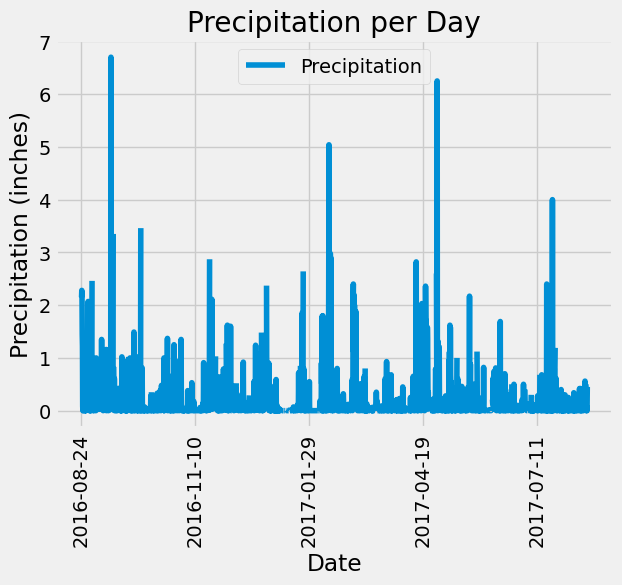

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
print(f'Most recent date in database is: {most_recent_date}')

# Calculate the date one year from the last date in data set.
one_yr_prior = (dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365))
print(f'One year from the most recent date: {one_yr_prior}')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_yr_prior).all()
precipitation_data[:5]

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
prcp_df.head()

# Sort the dataframe by date
prcp_df.set_index('Date', inplace=True)
prcp_df = prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
figure1 = prcp_df.plot(rot= 90)
figure1.set_title("Precipitation per Day")
figure1.set_ylabel("Precipitation (inches)")


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(station.id)).all()
total_stations

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_min = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
active_max = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
active_avg = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'The lowest temperature recorded at the most active station is: {active_min}')
print(f'The highest temperature recorded at the most active station is: {active_max}')
print(f'The average temperature recorded at the most active station is: {active_avg}')

The lowest temperature recorded at the most active station is: [(54.0,)]
The highest temperature recorded at the most active station is: [(85.0,)]
The average temperature recorded at the most active station is: [(71.66378066378067,)]


Text(0.5, 0, 'Temperature')

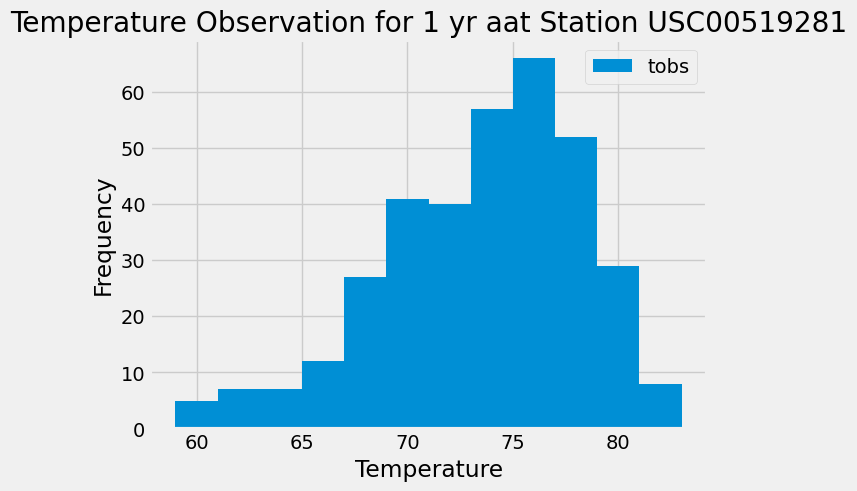

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_USC00519281 = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= one_yr_prior).all()
station_USC00519281[:5]

USC00519281_df = pd.DataFrame(station_USC00519281)
figure2 = USC00519281_df.plot(kind= 'hist', bins= 12)
figure2.set_title("Temperature Observation for 1 yr at Station USC00519281")
figure2.set_xlabel("Temperature")

# Close session

In [23]:
# Close Session
session.close()